In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fdm.src.fdm3t import fdm3t
from fdm.src.mfgrid import Grid
from scipy.special import k0
import etc

Wh(0.001, 0.3)  = (2.7449201210813685, 4.580772753804319e-09)
Wh(0.01, 0.3)   = (2.7104287908047175, 1.8261895390546826e-09)
Wh(0.1, 0.3)    = (1.6703650224009043, 5.50906758939597e-09)


In [2]:
dtypeQ   = np.dtype([('I', np.int32), ('q', float)])
dtypeH   = np.dtype([('I', np.int32), ('h', float)])
dtypeGHB = np.dtype([('I', np.int32), ('h', float), ('C', float)])

In [3]:

def deGlee(r=None, D=None, kr=None, kz=None, c=None, use_ghb=False, **kw):
    """Return De Glee output in a two-layer axially symmetric layer.

    Steady state is computed be setting all ss = 0.  if c is given ghb is used else, kz is use
    to set the resistance.

    Returns the besselfunction because Q = 2 * np.kD

    Parameters
    ----------
    gr: mfgrid.Grid object
        the grid
    kr, kz: float, 3D arrays of horizontal and vertical conductivities
        kr, kz conductivities
    """
    kD = (kr * D).sum()
    ctop = c
    L = np.sqrt(kD * c)
    Q = 2 * np.pi * kD

    z = -np.cumsum(np.hstack((0, D)))

    gr = Grid(r, [-0.5, 0.5], z, axial=True)

    kr = kr[:, np.newaxis, np.newaxis] * gr.const(1.)
    kz = kz[:, np.newaxis, np.newaxis] * gr.const(1.)

    fq = np.zeros(1, dtype=dtypeQ)
    fq['I'], fq['q'] = gr.NOD[-1, 0, 0], Q
    fq = {0: fq}

    if use_ghb:
        # use ghb instead of c. So fh must be None as well as c
        ghb = np.zeros(gr.nx * gr.ny, dtype=dtypeGHB)
        ghb['I'], ghb['C'], ghb['h'] = gr.NOD[-1].ravel(), gr.Area.ravel() / c, 0.
        ghb = {0: ghb}
        fh = None
        c = None
    else:
        #use c insteand of ghb, so ghb must be None and fh and c must be set to None
        fh = np.zeros(gr.nx * gr.ny, dtype=dtypeH)
        fh['I'], fh['h'] = gr.NOD[0].ravel(), 0.
        fh = {0: fh}
        c = gr.const(0.)[:-1]
        c[0] = ctop
        ghb = None

    idomain = gr.const(1, dtype=int)
    hi = gr.const(0.)

    out = fdm3t(gr=gr, t=None, k=(kr, kr, kz), c=c,
                fh=fh, fq=fq, ghb=ghb,
                hi=hi, idomain=idomain)

    ax = etc.newfig('De Glee example',
        'r [m]', 'drawdown',
        xscale='log', yscale='linear')
    ax.invert_yaxis()

    ax.plot(gr.xm, out['Phi'][-1, -1, 0, :], '.-', label='numerical')

    ax.plot(gr.xm, Q / (2 * np.pi * kD) * k0(gr.xm / L), '-', label='DeGlee')

    ax.legend()
    return ax


In [4]:
kwargs =  {'title': 'steady',
        "comment": """This test is to verify the accuracy of the model against an analytical
        solution of Theis or even Hantush by a regular simulation, no dimensionless parameters.
        """,
    't': np.logspace(-4, 9, 131),
    'r': np.hstack((0, np.logspace(-2, 6, 81))),
    'D': np.array([  10., 50.]),
    'kr': np.array([ 1e-6, 10.]),
    'kz': np.array([ 1e6,  1e6]),
    'Ss': np.array([ 0.01, 0.2e-6]),
    'c': np.array([600.]),
    'use_ghb': True,
    }

Running in axial mode, y-values are ignored.


<Axes: title={'center': 'De Glee example'}, xlabel='r [m]', ylabel='drawdown'>

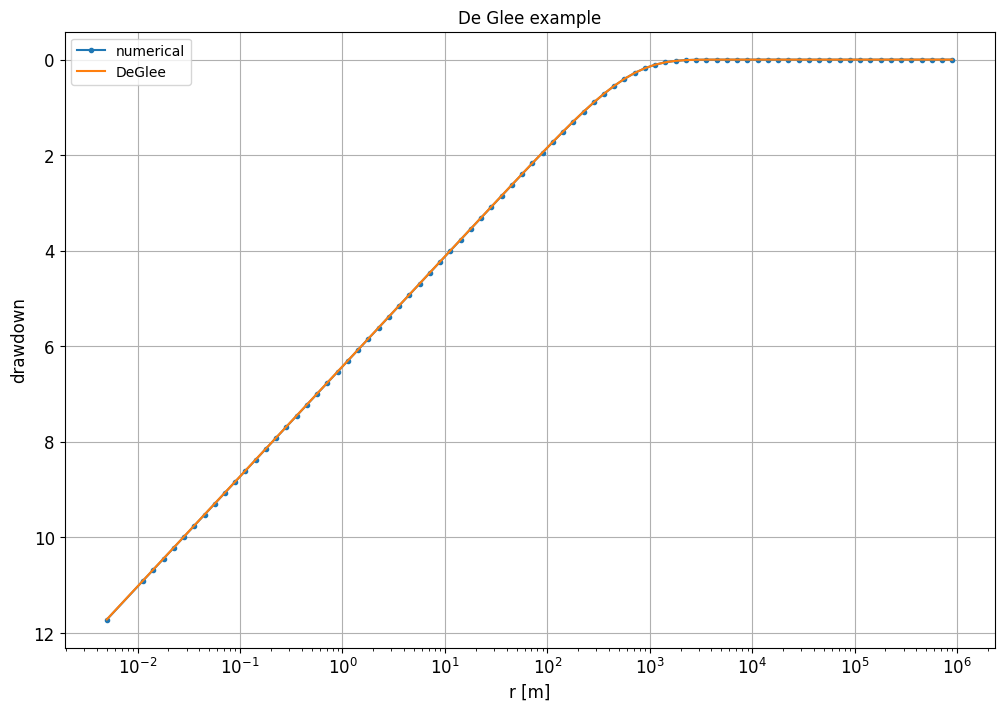

In [5]:
deGlee(**kwargs)